<a href="https://colab.research.google.com/github/yoelf22/getting-started-with-html/blob/master/eCommerce_Session_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

"""
🛍️ eCommerce Session Duration Analysis
📊 Finding the optimal processing time before user abandonment
🎯 Goal: Identify inflection points in success rates vs processing duration
"""
print("eCommerce Session Duration Analysis - Ready to Run!")

In [ ]:
# Install and import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
from scipy.optimize import minimize_scalar
import time
import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries loaded successfully!")
print(f"📅 Analysis started at: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries loaded successfully!
📅 Analysis started at: 2025-08-27 07:18:50


In [ ]:
# =============================================================================
# CONFIGURATION PARAMETERS
# =============================================================================

CONFIG = {
    'duration_min': 1,              # seconds
    'duration_increment': 2,        # seconds between session starts
    'success_center': 7.5,          # seconds - center point for success probability
    'n_sessions': 500,              # total number of sessions
    'bucket_width': 0.5,            # seconds - fixed bucket width
    'max_duration': 30,             # seconds - maximum expected duration
    'success_decay_steepness': 1.5, # controls sigmoid decay sharpness
    'unmatched_shopify_pct': 5,     # % of Shopify records without AWS match
    'unmatched_aws_pct': 3,         # % of AWS records without Shopify match
    'success_peak_rate': 0.95,      # peak success rate for short durations
    'success_min_rate': 0.05        # minimum success rate for long durations
}

print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration loaded:
  duration_min: 1
  duration_increment: 2
  success_center: 7.5
  n_sessions: 500
  bucket_width: 0.5
  max_duration: 30
  success_decay_steepness: 1.5
  unmatched_shopify_pct: 5
  unmatched_aws_pct: 3
  success_peak_rate: 0.95
  success_min_rate: 0.05


In [ ]:
# Cell 3 - Load sample data files
shopify_df = pd.read_csv('/content/sample_data/shopify_sample_data.csv')
aws_df = pd.read_csv('/content/sample_data/aws_sample_data.csv')

# Calculate duration from timestamps
aws_df['duration'] = aws_df['end_timestamp'] - aws_df['start_timestamp']

# Create original copies for reporting
shopify_original = shopify_df.copy()
aws_original = aws_df.copy()

print(f"Sample data loaded:")
print(f"  Shopify records: {len(shopify_df)}")
print(f"  AWS records: {len(aws_df)}")
print("\nShopify Data Sample:")
print(shopify_df.head())
print("\nAWS Data Sample:")
print(aws_df.head())

Sample data loaded:
  Shopify records: 70
  AWS records: 70

Shopify Data Sample:
     user_id   session_id  success
0  USER_5234  SESS_000001        1
1  USER_7821  SESS_000002        1
2  USER_3456  SESS_000003        1
3  USER_9123  SESS_000004        1
4  USER_2847  SESS_000005        1

AWS Data Sample:
     user_id   session_id  start_timestamp  end_timestamp  duration
0  USER_5234  SESS_000001       1724515200     1724515203         3
1  USER_7821  SESS_000002       1724518800     1724518805         5
2  USER_3456  SESS_000003       1724522400     1724522407         7
3  USER_9123  SESS_000004       1724526000     1724526004         4
4  USER_2847  SESS_000005       1724529600     1724529608         8


In [ ]:
# =============================================================================
# DATA JOINING AND ANALYSIS
# =============================================================================

def join_and_analyze_data(shopify_df, aws_df):
    """Join datasets and calculate unmatched record statistics"""

    # Perform inner join on session_id
    merged_df = pd.merge(shopify_df, aws_df, on='session_id', how='inner', suffixes=('_shopify', '_aws'))

    # Calculate unmatched statistics
    shopify_unmatched = len(shopify_df) - len(merged_df)
    aws_unmatched = len(aws_df) - len(merged_df)

    shopify_unmatched_pct = (shopify_unmatched / len(shopify_df)) * 100
    aws_unmatched_pct = (aws_unmatched / len(aws_df)) * 100

    print(f"\nData Joining Results:")
    print(f"  Matched records: {len(merged_df)}")
    print(f"  Shopify unmatched: {shopify_unmatched} ({shopify_unmatched_pct:.2f}%)")
    print(f"  AWS unmatched: {aws_unmatched} ({aws_unmatched_pct:.2f}%)")
    print(f"  Join success rate: {(len(merged_df) / max(len(shopify_df), len(aws_df))) * 100:.2f}%)")

    # STOP ANALYSIS if more than 10% mismatch
    total_unmatched_pct = max(shopify_unmatched_pct, aws_unmatched_pct)
    if total_unmatched_pct > 10.0:
        print(f"\n❌ STOPPING ANALYSIS: Mismatch rate ({total_unmatched_pct:.2f}%) exceeds 10% threshold!")
        print("   Data quality is too poor for reliable analysis.")
        print("   Please check data collection processes and try again.")
        return None, shopify_unmatched_records, aws_unmatched_records
    else:
        print(f"✅ Data quality acceptable: {total_unmatched_pct:.2f}% ≤ 10% threshold")

    # Store unmatched records separately
    shopify_unmatched_records = shopify_df[~shopify_df['session_id'].isin(merged_df['session_id'])]
    aws_unmatched_records = aws_df[~aws_df['session_id'].isin(merged_df['session_id'])]

    return merged_df, shopify_unmatched_records, aws_unmatched_records

# Join the data
result = join_and_analyze_data(shopify_df, aws_df)
if result[0] is None:
    print("Analysis terminated due to poor data quality.")
    exit()

merged_df, shopify_unmatched, aws_unmatched = result

# Sort by duration
merged_df = merged_df.sort_values('duration').reset_index(drop=True)

print(f"\nMerged Dataset Sample:")
print(merged_df[['session_id', 'duration', 'success']].head(10))


Data Joining Results:
  Matched records: 70
  Shopify unmatched: 0 (0.00%)
  AWS unmatched: 0 (0.00%)
  Join success rate: 100.00%)
✅ Data quality acceptable: 0.00% ≤ 10% threshold

Merged Dataset Sample:
    session_id  duration  success
0  SESS_000007         2        1
1  SESS_000001         3        1
2  SESS_000013         3        1
3  SESS_000022         3        1
4  SESS_000016         4        1
5  SESS_000004         4        1
6  SESS_000002         5        1
7  SESS_000010         5        1
8  SESS_000020         5        1
9  SESS_000008         6        1


In [ ]:
# =============================================================================
# BUCKET ANALYSIS
# =============================================================================

def create_duration_buckets(df):
    """Create fixed-width duration buckets and analyze success rates"""

    # Create bucket boundaries
    min_duration = df['duration'].min()
    max_duration = df['duration'].max()

    # Create bucket edges with fixed width
    bucket_edges = np.arange(min_duration, max_duration + CONFIG['bucket_width'], CONFIG['bucket_width'])

    # Assign bucket labels
    df['duration_bucket'] = pd.cut(df['duration'], bins=bucket_edges, include_lowest=True, right=False)

    # Calculate statistics for each bucket
    bucket_stats = []

    for bucket in df['duration_bucket'].cat.categories:
        bucket_data = df[df['duration_bucket'] == bucket]

        if len(bucket_data) > 0:
            mean_duration = bucket_data['duration'].mean()
            success_count = bucket_data['success'].sum()
            total_count = len(bucket_data)
            success_rate = success_count / total_count
        else:
            mean_duration = bucket.mid  # Use bucket midpoint if empty
            success_count = 0
            total_count = 0
            success_rate = np.nan  # Will handle in interpolation

        bucket_stats.append({
            'bucket_start': bucket.left,
            'bucket_end': bucket.right,
            'bucket_mid': bucket.mid,
            'mean_duration': mean_duration,
            'success_count': success_count,
            'total_count': total_count,
            'success_rate': success_rate
        })

    bucket_df = pd.DataFrame(bucket_stats)

    # Handle empty buckets with interpolation
    bucket_df = interpolate_empty_buckets(bucket_df)

    return bucket_df

def interpolate_empty_buckets(bucket_df):
    """Interpolate success rates for empty buckets"""

    # Find empty buckets (where total_count = 0)
    empty_mask = bucket_df['total_count'] == 0

    if empty_mask.any():
        print(f"Found {empty_mask.sum()} empty buckets - interpolating success rates")

        # For interpolation, use linear interpolation between non-empty buckets
        non_empty_indices = bucket_df[~empty_mask].index
        non_empty_success_rates = bucket_df.loc[non_empty_indices, 'success_rate']

        # Interpolate success rates
        interpolated_success_rates = np.interp(
            bucket_df.index,
            non_empty_indices,
            non_empty_success_rates
        )

        # Update empty buckets with interpolated values
        bucket_df.loc[empty_mask, 'success_rate'] = interpolated_success_rates[empty_mask]

    return bucket_df

# Create buckets and analyze
bucket_df = create_duration_buckets(merged_df)

print(f"\nBucket Analysis Results:")
print(f"  Total buckets: {len(bucket_df)}")
print(f"  Bucket width: {CONFIG['bucket_width']} seconds")
print(f"  Duration range: {bucket_df['bucket_start'].min():.2f} - {bucket_df['bucket_end'].max():.2f} seconds")

print(f"\nBucket Statistics Sample:")
print(bucket_df[['bucket_mid', 'mean_duration', 'total_count', 'success_rate']].head(10))

Found 29 empty buckets - interpolating success rates

Bucket Analysis Results:
  Total buckets: 58
  Bucket width: 0.5 seconds
  Duration range: 2.00 - 31.00 seconds

Bucket Statistics Sample:
   bucket_mid  mean_duration  total_count  success_rate
0        2.25           2.00            1           1.0
1        2.75           2.75            0           1.0
2        3.25           3.00            3           1.0
3        3.75           3.75            0           1.0
4        4.25           4.00            2           1.0
5        4.75           4.75            0           1.0
6        5.25           5.00            3           1.0
7        5.75           5.75            0           1.0
8        6.25           6.00            2           1.0
9        6.75           6.75            0           1.0


In [ ]:
# =============================================================================
# INFLECTION POINT DETECTION
# =============================================================================

def calculate_derivatives(bucket_df):
    """Calculate first and second derivatives of success rate"""

    success_rates = bucket_df['success_rate'].values
    durations = bucket_df['mean_duration'].values

    # First derivative (rate of change)
    first_derivative = np.gradient(success_rates, durations)

    # Second derivative (change in rate of change)
    second_derivative = np.gradient(first_derivative, durations)

    # Add derivatives to dataframe
    bucket_df['first_derivative'] = first_derivative
    bucket_df['second_derivative'] = second_derivative

    return bucket_df

def find_inflection_points(bucket_df):
    """Find inflection points using multiple methods"""

    inflection_points = []

    # Method 1: Second derivative zero crossings
    second_deriv = bucket_df['second_derivative'].values
    durations = bucket_df['mean_duration'].values

    # Find sign changes in second derivative
    sign_changes = np.where(np.diff(np.sign(second_deriv)))[0]

    for idx in sign_changes:
        # Interpolate to find more precise inflection point
        if idx < len(durations) - 1:
            x1, x2 = durations[idx], durations[idx + 1]
            y1, y2 = second_deriv[idx], second_deriv[idx + 1]

            # Linear interpolation to find zero crossing
            if y2 != y1:  # Avoid division by zero
                inflection_duration = x1 - y1 * (x2 - x1) / (y2 - y1)
            else:
                inflection_duration = (x1 + x2) / 2

            # Get success rate at inflection point
            success_rate = np.interp(inflection_duration, durations, bucket_df['success_rate'].values)
            first_deriv = np.interp(inflection_duration, durations, bucket_df['first_derivative'].values)

            inflection_points.append({
                'method': 'Second Derivative',
                'duration': inflection_duration,
                'success_rate': success_rate,
                'first_derivative': first_deriv,
                'significance': abs(y2 - y1)  # Magnitude of change
            })

    # Method 2: Largest drops in success rate (complement to mathematical method)
    first_deriv = bucket_df['first_derivative'].values
    min_deriv_idx = np.argmin(first_deriv)

    if min_deriv_idx > 0:  # Avoid edge cases
        inflection_points.append({
            'method': 'Steepest Decline',
            'duration': durations[min_deriv_idx],
            'success_rate': bucket_df.iloc[min_deriv_idx]['success_rate'],
            'first_derivative': first_deriv[min_deriv_idx],
            'significance': abs(first_deriv[min_deriv_idx])
        })

    return inflection_points

# Calculate derivatives and find inflection points
bucket_df = calculate_derivatives(bucket_df)
inflection_points = find_inflection_points(bucket_df)

print(f"\nInflection Points Found:")
for i, point in enumerate(inflection_points):
    print(f"  Point {i+1} ({point['method']}):")
    print(f"    Duration: {point['duration']:.3f} seconds")
    print(f"    Success Rate: {point['success_rate']:.3f}")
    print(f"    Rate of Change: {point['first_derivative']:.6f}")
    print(f"    Significance: {point['significance']:.6f}")


Inflection Points Found:
  Point 1 (Second Derivative):
    Duration: 2.000 seconds
    Success Rate: 1.000
    Rate of Change: 0.000000
    Significance: 0.000000
  Point 2 (Second Derivative):
    Duration: 11.767 seconds
    Success Rate: 0.644
    Rate of Change: -1.104630
    Significance: 0.625000
  Point 3 (Second Derivative):
    Duration: 13.667 seconds
    Success Rate: 0.361
    Rate of Change: 0.361111
    Significance: 0.375000
  Point 4 (Second Derivative):
    Duration: 15.500 seconds
    Success Rate: 0.222
    Rate of Change: -0.472222
    Significance: 0.250000
  Point 5 (Second Derivative):
    Duration: 17.000 seconds
    Success Rate: 0.000
    Rate of Change: 0.000000
    Significance: 0.166667
  Point 6 (Second Derivative):
    Duration: 19.000 seconds
    Success Rate: 0.000
    Rate of Change: 0.000000
    Significance: 0.250000
  Point 7 (Second Derivative):
    Duration: 20.500 seconds
    Success Rate: 0.167
    Rate of Change: 0.583333
    Significance: 0.

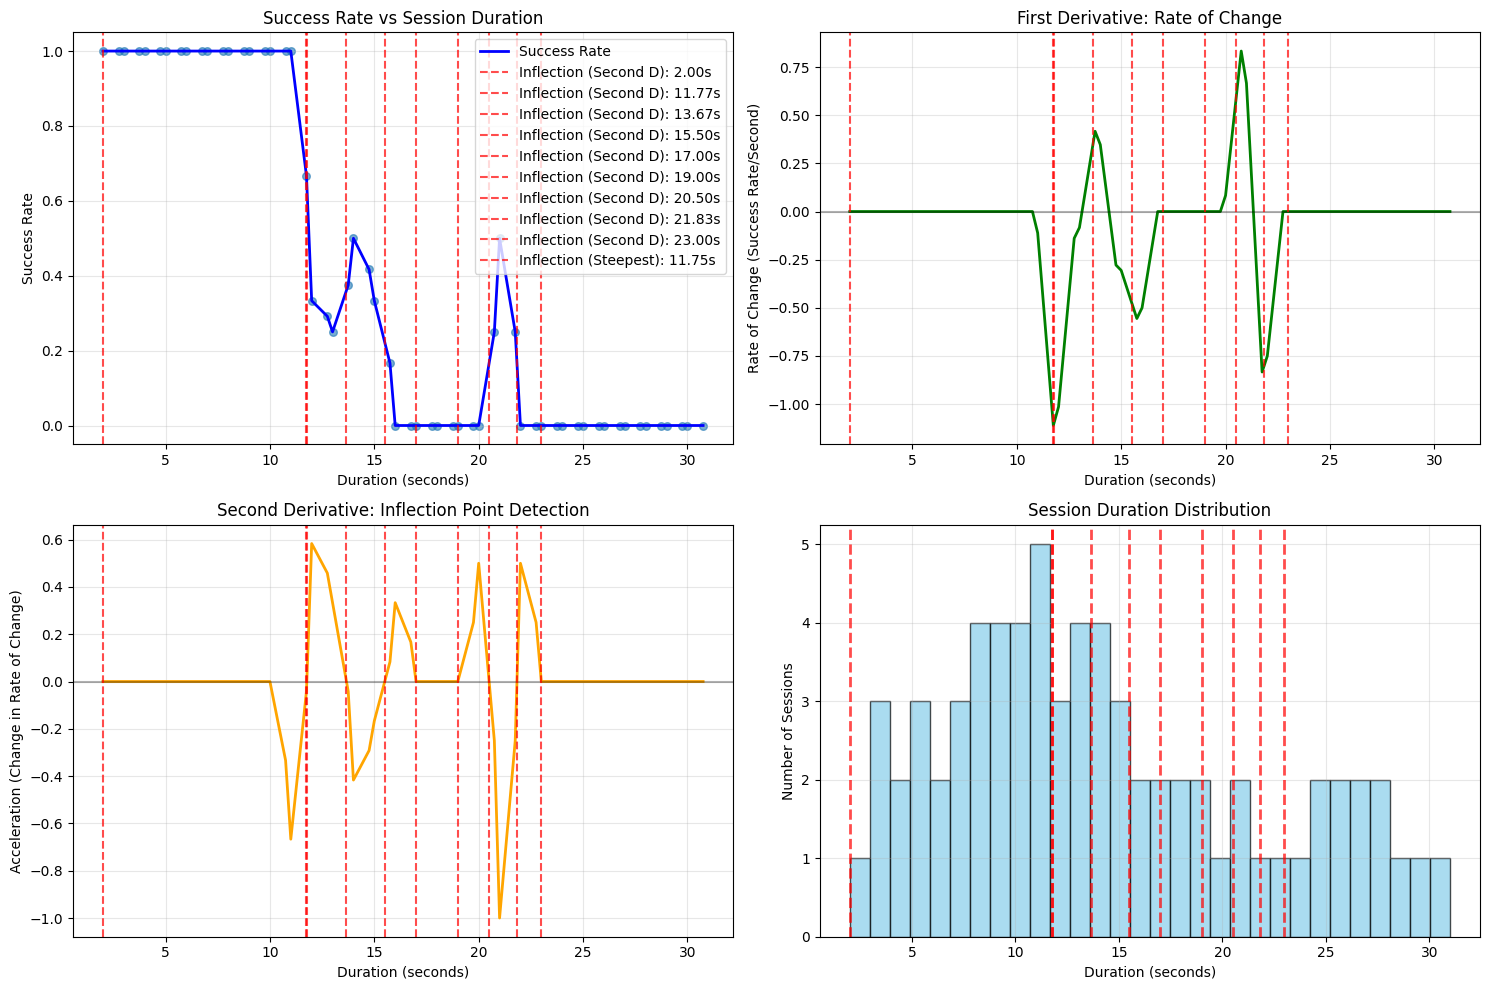

In [ ]:
# =============================================================================
# VISUALIZATION
# =============================================================================

def create_analysis_plots(bucket_df, inflection_points):
    """Create comprehensive visualization of the analysis"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Success Rate vs Duration
    ax1.plot(bucket_df['mean_duration'], bucket_df['success_rate'], 'b-', linewidth=2, label='Success Rate')
    ax1.scatter(bucket_df['mean_duration'], bucket_df['success_rate'], alpha=0.6, s=30)

    # Mark inflection points
    for point in inflection_points:
        ax1.axvline(x=point['duration'], color='red', linestyle='--', alpha=0.7,
                   label=f"Inflection ({point['method'][:8]}): {point['duration']:.2f}s")

    ax1.set_xlabel('Duration (seconds)')
    ax1.set_ylabel('Success Rate')
    ax1.set_title('Success Rate vs Session Duration')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot 2: First Derivative (Rate of Change)
    ax2.plot(bucket_df['mean_duration'], bucket_df['first_derivative'], 'g-', linewidth=2)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    for point in inflection_points:
        ax2.axvline(x=point['duration'], color='red', linestyle='--', alpha=0.7)

    ax2.set_xlabel('Duration (seconds)')
    ax2.set_ylabel('Rate of Change (Success Rate/Second)')
    ax2.set_title('First Derivative: Rate of Change')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Second Derivative (Acceleration)
    ax3.plot(bucket_df['mean_duration'], bucket_df['second_derivative'], 'orange', linewidth=2)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)

    for point in inflection_points:
        ax3.axvline(x=point['duration'], color='red', linestyle='--', alpha=0.7)

    ax3.set_xlabel('Duration (seconds)')
    ax3.set_ylabel('Acceleration (Change in Rate of Change)')
    ax3.set_title('Second Derivative: Inflection Point Detection')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Session Distribution
    ax4.hist(merged_df['duration'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')

    for point in inflection_points:
        ax4.axvline(x=point['duration'], color='red', linestyle='--', alpha=0.7, linewidth=2)

    ax4.set_xlabel('Duration (seconds)')
    ax4.set_ylabel('Number of Sessions')
    ax4.set_title('Session Duration Distribution')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

# Create visualizations
fig = create_analysis_plots(bucket_df, inflection_points)

In [ ]:
# =============================================================================
# SUMMARY RESULTS
# =============================================================================

def print_summary_results(inflection_points, bucket_df):
    """Print comprehensive summary of analysis results"""

    print("\n" + "="*60)
    print("           ANALYSIS SUMMARY RESULTS")
    print("="*60)

    print(f"\nDATA OVERVIEW:")
    print(f"  • Total analyzed sessions: {len(merged_df)}")
    print(f"  • Duration range: {merged_df['duration'].min():.2f} - {merged_df['duration'].max():.2f} seconds")
    print(f"  • Overall success rate: {merged_df['success'].mean():.3f}")
    print(f"  • Number of buckets: {len(bucket_df)}")

    print(f"\nINFLECTION POINTS DETECTED:")
    if inflection_points:
        for i, point in enumerate(inflection_points, 1):
            print(f"  {i}. {point['method']}")
            print(f"     Duration: {point['duration']:.3f} seconds")
            print(f"     Success Rate at Point: {point['success_rate']:.3f}")
            print(f"     Rate of Change: {point['first_derivative']:.6f}")
            print(f"     Significance Score: {point['significance']:.6f}")

        # Primary recommendation (most significant inflection point)
        primary_point = max(inflection_points, key=lambda x: x['significance'])
        print(f"\n  🎯 PRIMARY RECOMMENDATION:")
        print(f"     Optimal threshold: {primary_point['duration']:.3f} seconds")
        print(f"     Success rate begins declining significantly after this point")
    else:
        print("  No clear inflection points detected in the data.")

    print(f"\nBUSINESS INSIGHTS:")
    success_at_5s = np.interp(5.0, bucket_df['mean_duration'], bucket_df['success_rate'])
    success_at_10s = np.interp(10.0, bucket_df['mean_duration'], bucket_df['success_rate'])
    success_at_15s = np.interp(15.0, bucket_df['mean_duration'], bucket_df['success_rate'])

    print(f"  • Success rate at 5 seconds: {success_at_5s:.3f}")
    print(f"  • Success rate at 10 seconds: {success_at_10s:.3f}")
    print(f"  • Success rate at 15 seconds: {success_at_15s:.3f}")

    # Calculate sessions affected by different thresholds
    if inflection_points:
        primary_threshold = primary_point['duration']
        sessions_above_threshold = len(merged_df[merged_df['duration'] > primary_threshold])
        pct_above_threshold = (sessions_above_threshold / len(merged_df)) * 100

        print(f"  • Sessions exceeding optimal threshold ({primary_threshold:.2f}s): {sessions_above_threshold} ({pct_above_threshold:.1f}%)")
        print(f"  • Potential impact of optimization: Focus on improving {sessions_above_threshold} sessions")

def export_results():
    """Export analysis results for further use"""

    # Export bucket analysis
    bucket_export = bucket_df[['bucket_mid', 'mean_duration', 'total_count', 'success_rate',
                               'first_derivative', 'second_derivative']].copy()
    bucket_export.columns = ['Bucket_Center_Duration', 'Mean_Duration', 'Session_Count',
                            'Success_Rate', 'Rate_of_Change', 'Acceleration']

    print(f"\nExportable Results Generated:")
    print(f"  • Bucket analysis: {len(bucket_export)} rows")
    print(f"  • Inflection points: {len(inflection_points)} points")

    if inflection_points:
        inflection_df = pd.DataFrame(inflection_points)

        # Return primary inflection point as float
        primary_point = max(inflection_points, key=lambda x: x['significance'])
        primary_duration = float(primary_point['duration'])

        print(f"\n🎯 PRIMARY INFLECTION POINT DURATION: {primary_duration:.3f} seconds")
        return primary_duration, bucket_export, inflection_df
    else:
        return None, bucket_export, pd.DataFrame()

# Run final analysis
print_summary_results(inflection_points, bucket_df)
primary_inflection_duration, bucket_results, inflection_results = export_results()

print(f"\n" + "="*60)
print("✅ Analysis complete! All results are ready for use.")
print("="*60)